https://www.kaggle.com/c/whats-cooking/

In [1]:
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import torch
from torch.nn import functional as F

sns.set()

In [2]:
%%time
filename = "./whats-cooking/train.json"
with open(filename) as f:
    data_json = json.load(f)

CPU times: user 119 ms, sys: 9.59 ms, total: 129 ms
Wall time: 136 ms


In [3]:
data = pd.DataFrame(data_json)
data.shape

(39774, 3)

In [4]:
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [5]:
cuisine_counts = data['cuisine'].value_counts()
cuisines = cuisine_counts.index
print(len(cuisines))
cuisine_counts

20


cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

In [6]:
ingredient_counts = pd.Series(
    [ingredient.lower() for ingredient_list in data['ingredients'] for ingredient in ingredient_list]) \
    .value_counts()
print(len(ingredient_counts))
ingredient_counts

6703


salt                                   18049
onions                                  7972
olive oil                               7972
water                                   7457
garlic                                  7380
                                       ...  
low sodium fat free vegetable broth        1
garbonzo bean                              1
whole garam masala                         1
rose hip tea bags                          1
crushed cheese crackers                    1
Name: count, Length: 6703, dtype: int64

In [7]:
word_counts = pd.DataFrame(
    [(word.lower(), cnt) for ingredient, cnt in ingredient_counts.items() for word in ingredient.split(' ')],
    columns=['word', 'count']).groupby('word')['count'].sum().sort_values(ascending=False)
word_counts

word
pepper              25686
salt                24426
oil                 23323
garlic              18921
ground              18256
                    ...  
neapolitan              1
chocolatecovered        1
psyllium                1
knoflook                1
pane                    1
Name: count, Length: 3188, dtype: int64

In [8]:
n_ingredients = 500
ingredients = ingredient_counts.head(n_ingredients).index

In [9]:
ingredient_counts.head(n_ingredients)

salt                       18049
onions                      7972
olive oil                   7972
water                       7457
garlic                      7380
                           ...  
boneless chicken breast      146
cooked white rice            145
crème fraîche                145
pecans                       144
panko breadcrumbs            144
Name: count, Length: 500, dtype: int64

In [10]:
ingredients
data['top_ingredients'] = data['ingredients'].map(lambda x: sorted(set(x).intersection(ingredients)))
data['n_top_ingredients'] = data['top_ingredients'].map(len)
data['n_top_ingredients'].max()

53

In [11]:
data.head()

,id,cuisine,ingredients,top_ingredients,n_top_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[black olives, feta cheese crumbles, garbanzo ...",8
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[eggs, ground black pepper, ground pepper, mil...",10
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[butter, cooking oil, eggs, garlic powder, gre...",10
3,22213,indian,"[water, vegetable oil, wheat, salt]","[salt, vegetable oil, water]",3
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[bay leaf, black pepper, boneless chicken skin...",16


<Axes: >

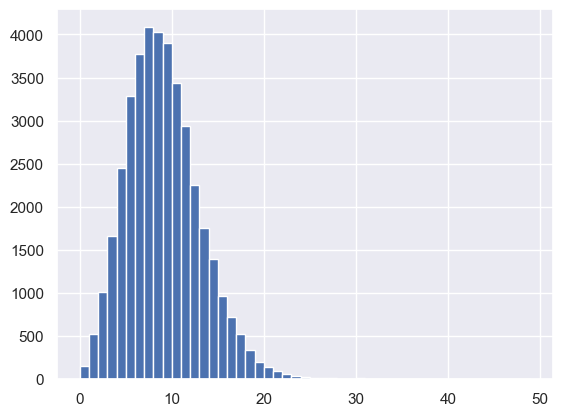

In [12]:
data['n_top_ingredients'].hist(bins=np.arange(50))

In [13]:
(data['n_top_ingredients'] <= 15).mean()

0.945391461758938

#### create dataset to train model

In [14]:
len(data)

39774

In [15]:
ingredients
ingredient_to_i = dict(zip(ingredients, range(len(ingredients))))
cuisine_to_i = dict(zip(cuisines, range(len(cuisines))))

In [16]:
data['top_ingredients_i'] = data['top_ingredients'].map(
    lambda x: sorted(ingredient_to_i[y] for y in x))
data['cuisine_i'] = data['cuisine'].map(cuisine_to_i)

In [17]:
data.head()

,id,cuisine,ingredients,top_ingredients,n_top_ingredients,top_ingredients_i,cuisine_i
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[black olives, feta cheese crumbles, garbanzo ...",8,"[4, 10, 27, 217, 297, 341, 342, 492]",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[eggs, ground black pepper, ground pepper, mil...",10,"[0, 8, 11, 12, 16, 23, 202, 216, 239, 482]",2
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[butter, cooking oil, eggs, garlic powder, gre...",10,"[0, 7, 10, 12, 13, 48, 64, 106, 108, 154]",15
3,22213,indian,"[water, vegetable oil, wheat, salt]","[salt, vegetable oil, water]",3,"[0, 3, 11]",3
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[bay leaf, black pepper, boneless chicken skin...",16,"[0, 1, 3, 7, 20, 22, 23, 24, 25, 43, 47, 50, 8...",3


In [18]:
n_context = 10  # sample some ingredients from full list (pad with EMPTY if less so)
n_samples = 5  # do not sample more than 10 times from same recipe

In [19]:
%%time
np.random.seed(123)
# create rows with combinations from the recipes
features, labels = [], []
for _, recipe in data.iterrows():
    if recipe['top_ingredients']:
        draws = np.random.choice(recipe['top_ingredients_i'], (n_samples, n_context), replace=True)
        labels.extend(n_samples * [recipe['cuisine_i']])
        for draw in draws:
            features.append(draw)
features, labels = np.array(features), np.array(labels)            

CPU times: user 917 ms, sys: 14.4 ms, total: 931 ms
Wall time: 929 ms


In [20]:
features.shape

(198130, 10)

In [21]:
features, labels

(array([[342, 341, 342, ...,  10, 217,  27],
        [217,  10, 342, ..., 492,  10,   4],
        [342,   4, 492, ..., 297,   4,   4],
        ...,
        [  4,  36,  35, ...,  35,  65,  35],
        [ 73, 102,  36, ..., 266,  34, 344],
        [344, 344,  73, ..., 266, 266,   4]]),
 array([9, 9, 9, ..., 1, 1, 1]))

#### create model

In [22]:
dtype = torch.float
device = "cpu" 
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [23]:
X_t, y_t = torch.Tensor(features).int(), torch.Tensor(labels).int()
X_t, y_t = X_t.to(device), y_t.to(device)

np.random.seed(123)
idx = np.random.random(len(X_t)) < .8
X_train, X_test, y_train, y_test = X_t[idx], X_t[~idx], y_t[idx], y_t[~idx]

In [24]:
g = torch.Generator(device=device).manual_seed(123) # for reproducibility
ingredient_emb_dim = 2
ingredient_emb = torch.randn((n_ingredients, ingredient_emb_dim), generator=g)
ingredient_emb[:5]

tensor([[ 2.2035,  0.4599],
        [ 0.5828, -0.5727],
        [-1.7389, -0.1414],
        [-1.7129, -0.3694],
        [ 0.5239,  0.4470]], device='mps:0')

In [25]:
input_layer_dim = ingredient_emb_dim * n_context
n_hidden_neurons = 100  # or 100?
hidden_layer_dim = ingredient_emb_dim * n_hidden_neurons
n_output_dim = len(cuisines)

g = torch.Generator(device=device).manual_seed(123) # for reproducibility
C = torch.randn((n_ingredients, ingredient_emb_dim), generator=g, dtype=dtype, requires_grad=True)  # ingr. emb.
W1 = torch.randn((input_layer_dim, hidden_layer_dim), generator=g, dtype=dtype, requires_grad=True)
b1 = torch.randn(hidden_layer_dim, generator=g, dtype=dtype, requires_grad=True)
W2 = torch.randn((hidden_layer_dim, n_output_dim), generator=g, dtype=dtype, requires_grad=True)
b2 = torch.randn(n_output_dim, generator=g, dtype=dtype, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

9220

In [27]:
%%time
# n_epochs = int(1e3)  # passes through full data set
batch_size = len(X_train) // 100
n_steps = 1 + int(2e3)  # n_epochs * len(X_t) // batch_size
n_prints = 10
learning_rates = 10 ** np.linspace(0, -3, n_steps)
# learning_rates = 1 * np.ones(n_steps)
# learning_rate = 1
stats = []

for i in range(n_steps):
  
    # forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size,))  # minibatch construct
    emb = C[X_train[ix]]  # (few rows, few tokens, few-dim embeddings)    
    h = torch.tanh(emb.view(-1, input_layer_dim) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y_train[ix]) + (C ** 2).mean()  # L2 regularization
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = learning_rates[i]
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # track stats
    stats.append({
        'i': i,
        'tr log loss': loss.log10().item(),
    })
        

    if i % (n_steps // n_prints) == 0:
        # extra evals
        aucs, accs = [], []
        for cuisine_i in range(len(cuisines)):
            pos = (y_train[ix] == cuisine_i).cpu().data
            auc = roc_auc_score(pos, logits[:, cuisine_i].cpu().data) if pos.any() and not pos.all() else None
            acc = (pos == (cuisine_i == logits.argmax(axis=1)).cpu()).float().mean().item()
            stats[-1]['%s tr auc' % cuisines[cuisine_i]] = auc
            stats[-1]['%s tr acc' % cuisines[cuisine_i]] = acc
            aucs.append((auc, pos.sum()))
            accs.append((acc, pos.sum()))
        auc = sum(auc * n for auc, n in aucs) / len(ix)
        acc = sum(acc * n for acc, n in accs) / len(ix)
        stats[-1]['avg tr auc'] = auc.item()
        stats[-1]['avg tr acc'] = acc.item()
        acc = (y_train[ix] == logits.argmax(axis=1)).cpu().float().mean().item()
        stats[-1]['multi-class tr acc'] = acc
                    
#         # test
#         ix = torch.randint(0, X_t.shape[0], (batch_size,))  # minibatch construct
#         emb = C[X_train[ix]]  # (few rows, few tokens, few-dim embeddings)    
#         h = torch.tanh(emb.view(-1, input_layer_dim) @ W1 + b1)
#         logits = h @ W2 + b2 # (32, 27)
#         loss = F.cross_entropy(logits, y_train[ix]) + (C ** 2).mean()  # L2 regularization

        print("%6s  loss %7.4f  auc %.4f  acc %.4f" % (i, loss.data, auc, acc))

stats = pd.DataFrame(stats).set_index('i')    

     0  loss 24.7455  auc 0.5052  acc 0.0600
   200  loss  3.3995  auc 0.6798  acc 0.2210
   400  loss  2.1944  auc 0.7630  acc 0.4306
   600  loss  2.0776  auc 0.7746  acc 0.4242
   800  loss  1.9469  auc 0.7885  acc 0.4703
  1000  loss  1.9191  auc 0.7955  acc 0.4400
  1200  loss  1.8844  auc 0.8007  acc 0.4710
  1400  loss  1.8552  auc 0.7999  acc 0.4804
  1600  loss  1.8733  auc 0.7989  acc 0.4710
  1800  loss  1.8316  auc 0.8046  acc 0.4867
  2000  loss  1.9473  auc 0.7927  acc 0.4615
CPU times: user 4.52 s, sys: 643 ms, total: 5.17 s
Wall time: 7.74 s


In [28]:
stats.dropna(how='any')

,tr log loss,italian tr auc,italian tr acc,mexican tr auc,mexican tr acc,southern_us tr auc,southern_us tr acc,indian tr auc,indian tr acc,chinese tr auc,...,irish tr acc,jamaican tr auc,jamaican tr acc,russian tr auc,russian tr acc,brazilian tr auc,brazilian tr acc,avg tr auc,avg tr acc,multi-class tr acc
i,,,,,,,,,,,,,,,,,,,,,
0,1.393497,0.514133,0.752525,0.474633,0.804924,0.499925,0.871212,0.505503,0.868056,0.524526,...,0.950758,0.525751,0.890152,0.560691,0.960227,0.539286,0.968434,0.505249,0.861967,0.059975
200,0.531420,0.772041,0.824495,0.796396,0.875631,0.602319,0.650884,0.629006,0.901515,0.774090,...,0.970328,0.577140,0.984848,0.596899,0.979167,0.551987,0.973485,0.679775,0.862422,0.220960
400,0.341309,0.837543,0.816288,0.876033,0.864268,0.625041,0.803030,0.793472,0.909722,0.825918,...,0.981061,0.534229,0.984848,0.584015,0.986742,0.775153,0.987374,0.763002,0.891265,0.430556
600,0.317557,0.854918,0.793561,0.874247,0.886364,0.658407,0.798611,0.783936,0.909722,0.876345,...,0.979798,0.571455,0.989899,0.607470,0.985480,0.739636,0.989268,0.774598,0.892811,0.424242
800,0.289344,0.885082,0.832071,0.897737,0.897096,0.689551,0.804924,0.781511,0.898359,0.861489,...,0.989268,0.602369,0.982955,0.518350,0.987374,0.581106,0.986111,0.788540,0.898568,0.470328
1000,0.283092,0.881370,0.808081,0.877846,0.899621,0.713695,0.796086,0.825798,0.906566,0.877556,...,0.982955,0.576829,0.987374,0.617856,0.986111,0.730584,0.982955,0.795455,0.894946,0.440025
1200,0.275168,0.885723,0.818182,0.905395,0.914141,0.694981,0.808081,0.782814,0.898359,0.888300,...,0.981692,0.546835,0.989268,0.539919,0.990530,0.675250,0.990530,0.800666,0.899141,0.470960
1400,0.268392,0.887426,0.827020,0.895009,0.914773,0.706245,0.814394,0.804479,0.910985,0.879782,...,0.979798,0.602507,0.990530,0.602639,0.989899,0.679797,0.991793,0.799945,0.905082,0.480429
1600,0.272605,0.898834,0.827652,0.903265,0.907828,0.687434,0.809343,0.814448,0.907197,0.862968,...,0.984848,0.647498,0.991162,0.527122,0.989268,0.692129,0.989899,0.798881,0.899429,0.470960


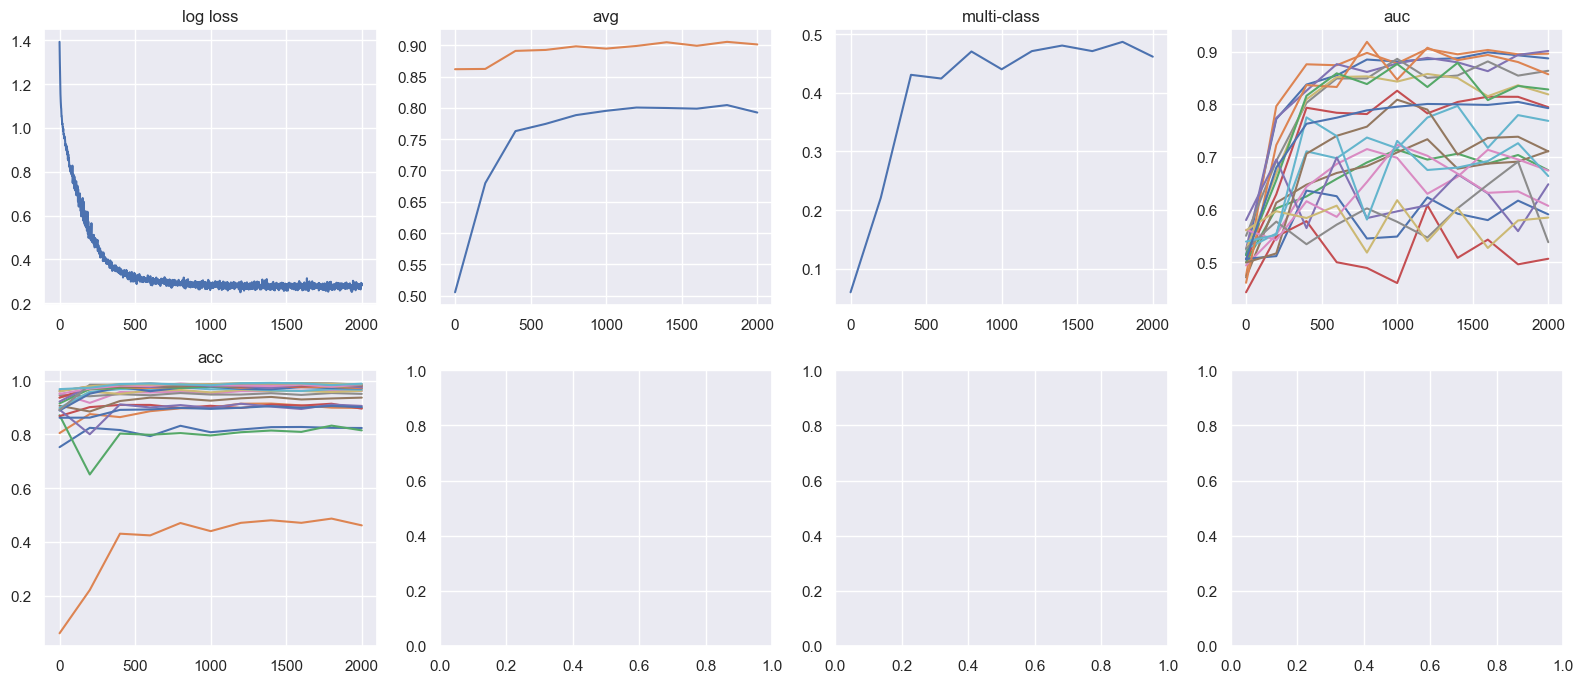

In [29]:
metrics = ['log loss', 'avg', 'multi-class', 'auc', 'acc']
n_cols = 4
_, axs = plt.subplots(len(metrics) // n_cols + 1, n_cols, figsize=(16, 7))
for ax, metric in zip(axs.reshape(-1), metrics):
    cols = [col for col in stats.columns if metric in col]
    stats[cols].dropna(how='any').plot(ax=ax, legend=False)
    ax.set_title(metric), ax.set_xlabel('')
    ax.set_alpha(0)
plt.tight_layout()

In [30]:
metric = 'avg'
cols = [col for col in stats.columns if metric in col]
if metric == 'avg':
    cols += [col for col in stats.columns if 'multi-class' in col]
stats[cols].dropna(how='any').plot(ax=ax, legend=False)
ax.set_title(metric)
ax.set_alpha(0)

stats[cols].dropna(how='any')

,avg tr auc,avg tr acc,multi-class tr acc
i,,,
0,0.505249,0.861967,0.059975
200,0.679775,0.862422,0.220960
400,0.763002,0.891265,0.430556
600,0.774598,0.892811,0.424242
800,0.788540,0.898568,0.470328
1000,0.795455,0.894946,0.440025
1200,0.800666,0.899141,0.470960
1400,0.799945,0.905082,0.480429
1600,0.798881,0.899429,0.470960


In [31]:
# stats.dropna(how='any')

<Axes: >

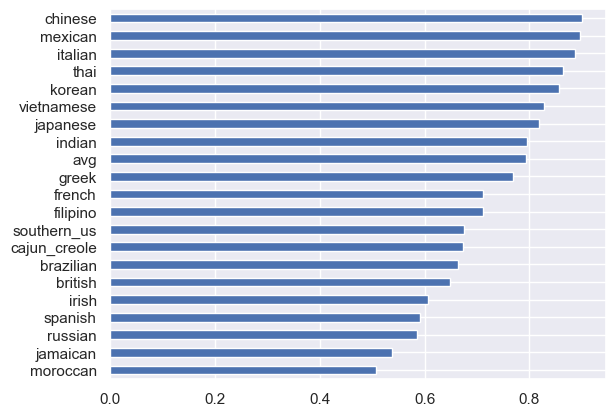

In [32]:
auc_cols = [col for col in stats.columns if 'auc' in col]
s = stats[auc_cols].tail().mean().sort_values()  # ascending=False)
s.index = s.index.str.replace(' tr auc', '')
s.plot(kind='barh')

### embedding analysis

In [33]:
ingr_emb = pd.DataFrame(C.cpu().data, index=ingredients)
ingr_emb['counts'] = ingredient_counts
ingr_emb['r'] = np.sqrt(np.square(ingr_emb[[0, 1]]).sum(axis=1))
ingr_emb.head()

,0,1,counts,r
salt,-0.027124,-0.028151,18049,0.039092
onions,-0.015627,-0.051789,7972,0.054095
olive oil,-0.056135,0.065719,7972,0.086430
water,-0.067888,-0.031131,7457,0.074685
garlic,-0.070393,-0.021580,7380,0.073626


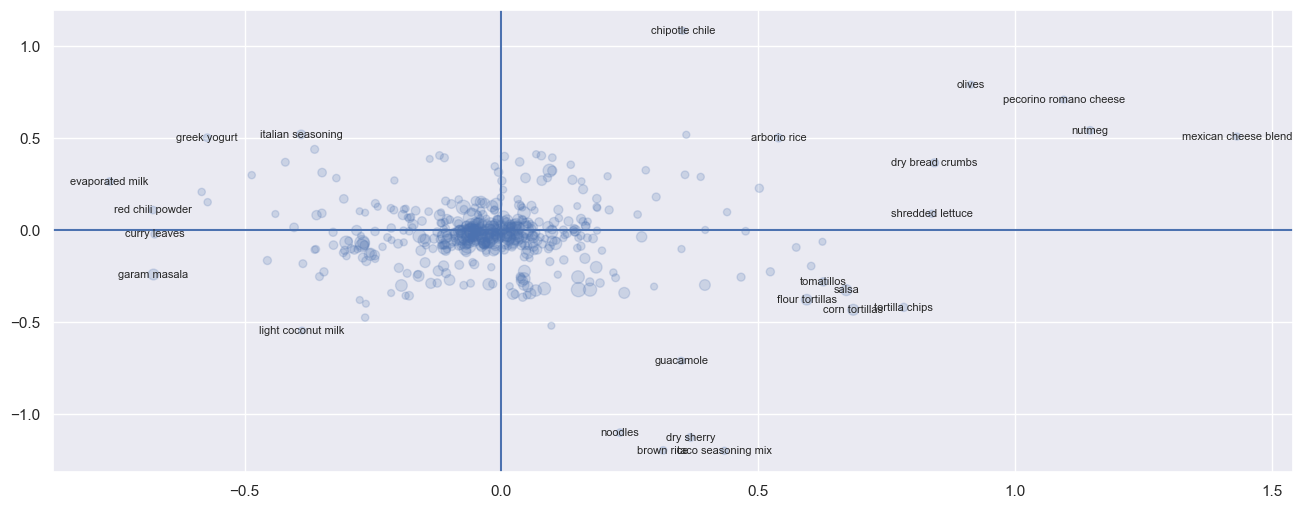

In [34]:
_, ax = plt.subplots(figsize=(16, 6))
ax.scatter(ingr_emb[0], ingr_emb[1], s=2 * np.sqrt(ingr_emb['counts']), alpha=.2)
ax.axhline(), ax.axvline()
idx = ingr_emb['r'] > ingr_emb['r'].quantile(.95)
for label, coord in ingr_emb[idx].iterrows():
    ax.text(coord[0], coord[1], label.replace(' ', ' '), ha='center', va='center', fontsize=8)

In [35]:
coord_norm = ingr_emb[[0, 1]].values / ingr_emb['r'].values.reshape(-1, 1)
ingr_emb['x'] = coord_norm[:, 0]
ingr_emb['y'] = coord_norm[:, 1]

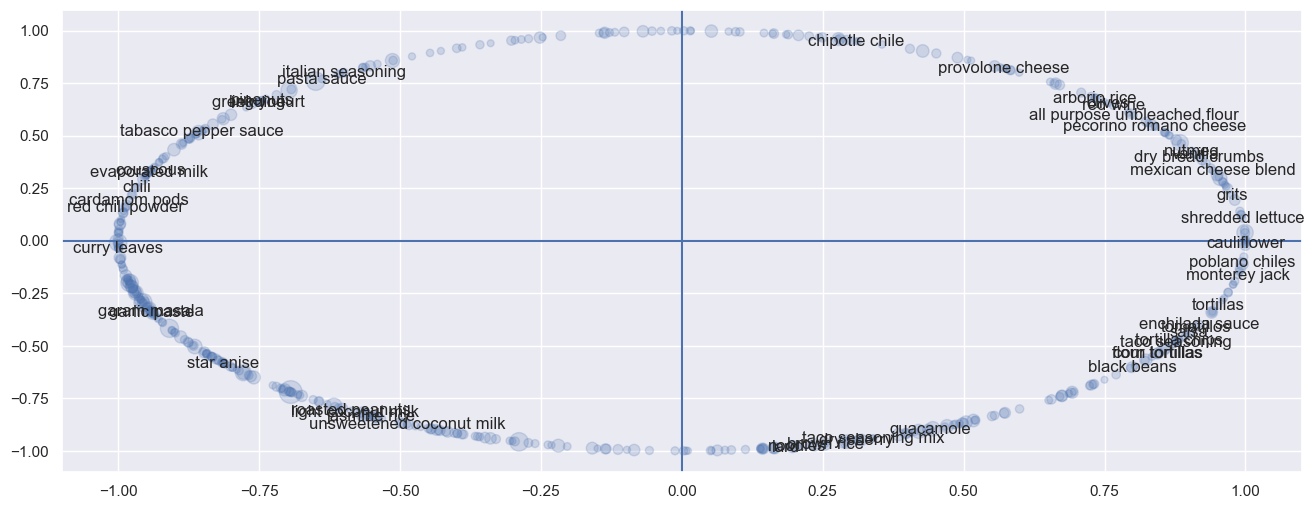

In [36]:
_, ax = plt.subplots(figsize=(16, 6))
ax.scatter(ingr_emb['x'], ingr_emb['y'], s=2 * np.sqrt(ingr_emb['counts']), alpha=.2)
ax.axhline(), ax.axvline()
idx = ingr_emb['r'] > ingr_emb['r'].quantile(.9)
for label, coord in ingr_emb[idx].iterrows():
    ax.text(coord['x'], coord['y'], label.replace(' ', ' '), ha='center', va='center', fontsize=12)

In [38]:
M = pd.DataFrame(coord_norm.dot(coord_norm.T), index=ingredients, columns=ingredients)
order = M.mean().sort_values().index
M = M.loc[order, order]

<Axes: >

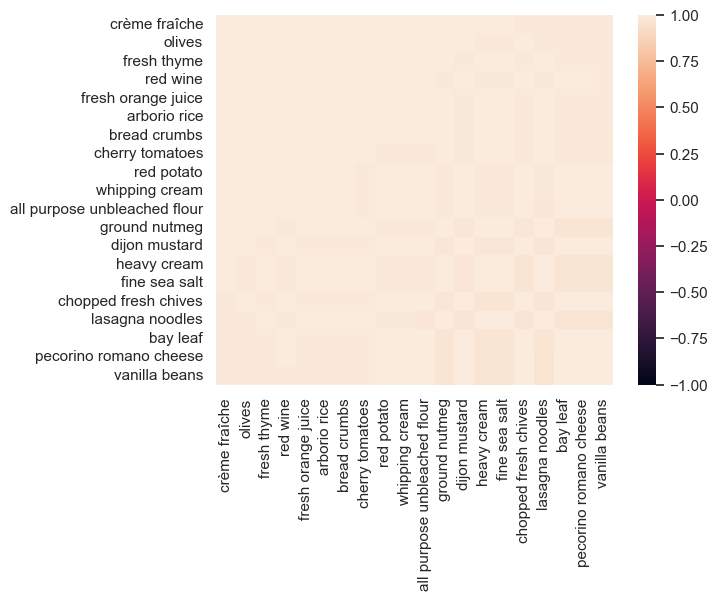

In [39]:
sns.heatmap(M.iloc[:20, :20], vmin=-1, vmax=1)

<Axes: >

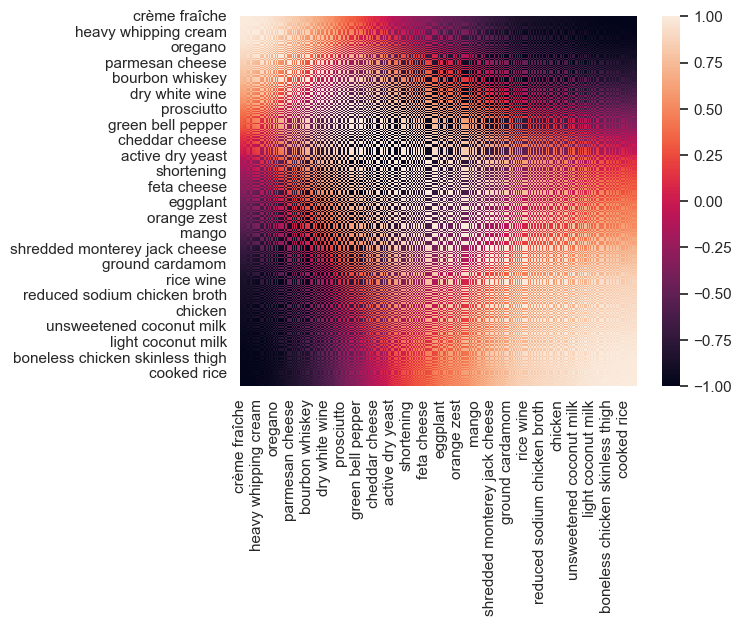

In [40]:
sns.heatmap(M)